# Simulate model objects and brain objects 

As mentioned in the previous tutorials, you can also simulate data.  You can simulate brain objects or you can simulate a list of brain objects to create a model.  In this tutorial, we will walk you through the simulate functions and explore varying parameters. 

# Load in the required libraries

In [1]:
import superEEG as se
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#from nilearn import plotting
#from nilearn import image
import numpy as np

/Library/Python/2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Simulate locations

To begin, we can either simulate locations: 

In [2]:
sim_locs = se.simulate_locations()
sim_locs.head()

,x,y,z
0,46,-1,-47
1,-5,0,-29
2,-36,26,-42
3,-30,-33,2
4,-44,-29,39


Or extract example locations:

In [4]:
# load example locations
gray = se.load('example_locations')
locs.head()

,x,y,z
0,-50.0,-66.0,8.0
1,-50.0,-46.0,-12.0
2,-50.0,-46.0,8.0
3,-50.0,-46.0,28.0
4,-50.0,-26.0,-12.0


# Simulate brain object

By default, the `simualate_bo` function will return a 1000 samples by 10 electrodes matrix, but you can specify the number of time samples with `n_samples`, sessions with `sessions`, and the number of electrodes with `n_elecs` or by passing speficic electrodes with `locs`. 

In [7]:
# simulate brain object with example locations
bo = se.simulate_bo(n_samples=1000, sample_rate=100, sessions=2, locs=locs)

You can view your simulated data with `bo.plot_data` and simulated locations with `bo.plot_locs`.

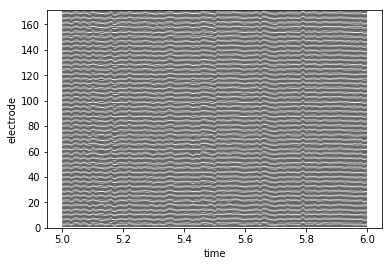

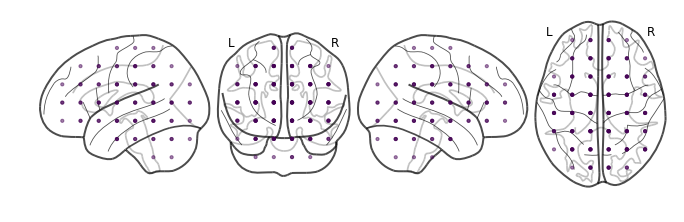

In [9]:
# default time window is first 10 seconds, but you can specifiy your own window
bo.plot_data(time_min=5, time_max=6)
bo.plot_locs()

We've also added a `random_seed=False` and `noise=.1` parameters.  If you want to recreate the same brain object, you can set these flags to: `random_seed=True` and `noise=0`

In [10]:
# you can also specify a random seed and set the noise parameter to 0 
# if you want to simulate the same brain object again

data1 = se.simulate_bo(n_samples=1000, sessions=2, n_elecs=5, random_seed=True, noise=0).get_data()
data2 = se.simulate_bo(n_samples=1000, sessions=2, n_elecs=5, random_seed=True, noise=0).get_data()
np.allclose(data1, data2)

True

Lastly, if you want to subset the full brain object to a smaller set of locations, you can pass the desired number of electrodes in to 

Then, we simulate a correlation matrix (toeplitz) to impose
on the simulated subject data. 

In [ ]:
# simulate correlation matrix
# options for covariance matrix: 'toeplitz', 'eye', 'distance' or 'random'
R = se.create_cov(cov='toeplitz', n_elecs=len(locs))

We will parametrically vary how many subjects and how many
electrodes per subject are used to create the model. We loop over number of subjects and
number of randomly chosen electrodes and plot the model at each iteration. As
the figure shows, the more subjects and electrodes, the better then recovery of
the true model.

In [ ]:
# n_samples
n_samples = 10

# initialize subplots
f, axarr = plt.subplots(4, 4)

# loop over simulated subjects size
for isub, n_subs in enumerate([10, 25, 50, 100]):

    # loop over simulated electrodes
    for ielec, n_elecs in enumerate([10, 25, 50, 100]):

        # simulate brain objects for the model
        model_bos = [se.simulate_model_bos(n_samples=n_samples, sample_rate=10, locs=locs,
                                           sample_locs=n_elecs, cov='toeplitz') for x in range(n_subs)]

        # create the model object
        model = se.Model(data=model_bos, locs=locs)

        # plot it
        sns.heatmap(np.divide(model.numerator, model.denominator), ax=axarr[isub, ielec], yticklabels=False,
                    xticklabels=False, cmap='RdBu_r', cbar=False, vmin=0, vmax=3)

        # set the title
        axarr[isub, ielec].set_title(str(n_subs) + ' Subjects, ' + str(n_elecs) + ' Electrodes')

plt.tight_layout()
plt.show()

In [ ]:
# -*- coding: utf-8 -*-
"""
=============================
Create a model from scratch, and then update it with new subject data
=============================

In this example, we will simulate a model and some data, and see if we can
recover the model from the data. First, we'll load in some example locations.
Then, we will simulate correlational structure (a toeplitz matrix) to impose on
our simulated data.  This will allow us to test whether we can recover the
correlational structure in the data, and how that changes as a function of the
number of subjects in the model. Then, we will simulate 10 subjects and create
brain objects with their data.  The left figure shows the model derived from
10 simulated subjects.  Finally, we simulate 10 additional subjects and use the
model.update method to update an existing model with new data. On the right, the
updated model is plotted. As is apparent from the figures, the more data in the
model, the better the true correlational structure can be recovered.

"""

# Code source: Andrew Heusser & Lucy Owen
# License: MIT

# import libraries
from builtins import range
import os
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import superEEG as se

# load example model to get locations
locs = se.load('example_locations')

# convert to pandas
locs=pd.DataFrame(locs, columns=['x', 'y', 'z'])

# simulate correlation matrix
R = se.create_cov(cov='toeplitz', n_elecs=len(locs))

# number of timeseries samples
n_samples = 1000

# number of subjects
n_subs = 10

# number of electrodes
n_elecs = 20

# simulate brain objects for the model that subsample n_elecs for each synthetic patient
model_bos = [se.simulate_model_bos(n_samples=1000, sample_rate=1000, locs=locs, sample_locs=n_elecs, cov='toeplitz') for x in
                     range(n_subs)]

# create the model object
model = se.Model(data=model_bos, locs=locs)

# brain object locations subsetted entirely from both model and gray locations - for this n > m (this isn't necessarily true, but this ensures overlap)
sub_locs = locs.sample(n_elecs).sort_values(['x', 'y', 'z'])

# simulate a new brain object using the same covariance matrix
bo = se.simulate_bo(n_samples=1000, sample_rate=1000, locs=sub_locs, cov='toeplitz')

# update the model
new_model = model.update(bo)

# simulate brain objects for the model that subsample n_elecs for each synthetic patient
model_update_bos = [se.simulate_model_bos(n_samples=1000, sample_rate=1000, locs=locs, sample_locs=n_elecs, cov='toeplitz') for y in
                     range(n_subs)]

# update the model
better_model = model.update(model_update_bos)

# initialize subplots
f, (ax1, ax2, ax3) = plt.subplots(1, 3)

# plot it and set the title
model.plot(ax=ax1, yticklabels=False, xticklabels=False, cmap='RdBu_r', cbar=True, vmin=0, vmax=1)
ax1.set_title('Before updating model: 10 subjects total')

# plot it and set the title
new_model.plot(ax=ax2, yticklabels=False, xticklabels=False, cmap='RdBu_r', cbar=True, vmin=0, vmax=1)
ax2.set_title('After updating model: 11 subjects total')

# plot it and set the title
better_model.plot(ax=ax3, yticklabels=False, xticklabels=False, cmap='RdBu_r', cbar=True, vmin=0, vmax=1)
ax3.set_title('After updating model: 20 subjects total')

plt.show()

Next, we will simulate a model and some data, and see if we can
recover the model from the data. 

First, we'll load in some example locations.
Then, we will simulate correlational structure (a toeplitz matrix) to impose on
our simulated data.  This will allow us to test whether we can recover the
correlational structure in the data, and how that changes as a function of the
number of subjects in the model. Then, we will simulate 10 subjects and create
brain objects with their data.  The left figure shows the model derived from
10 simulated subjects.  Finally, we simulate 10 additional subjects and use the
model.update method to update an existing model with new data. On the right, the
updated model is plotted. As is apparent from the figures, the more data in the
model, the better the true correlational structure can be recovered.

Next, we simulate 10 brain objects using a subset of locations and the correlational structure
(a toeplitz matrix) to create the model. 

We then update that model with
one simulated brain object, also create from a subset of locations and the
correlational structure (a toeplitz matrix). Finally, we update the model with
10 more brain objects following the same simulation procedure above.

In [ ]:
# # n_samples
# n_samples = 1000
#
# # n_electrodes - number of electrodes for reconstructed patient
# n_elecs = range(5, 165, 50)
#
# # m_patients - number of patients in the model 
# m_patients = [5, 10]
#
# # m_electrodes - number of electrodes for each patient in the model
# m_elecs = range(5, 165, 50)
#
# iter_val = 1
#
#
#
# append_d = pd.DataFrame()
#
# param_grid = [(p,m,n) for p in m_patients for m in m_elecs for n in n_elecs]
#
# for p, m, n in param_grid:
#     d = []
#
#     for i in range(iter_val):
#
#
#         #create brain objects with m_patients and loop over the number of model locations and subset locations to build model
#         model_bos = [se.simulate_model_bos(n_samples=1000, sample_rate=1000, locs=locs, sample_locs = m) for x in range(p)]
#
#         model_locs = pd.DataFrame()
#         for i in range(len(model_bos)):
#             model_locs = model_locs.append(model_bos[i].locs, ignore_index = True)
#
#         # create model from subsampled gray locations
#         model = se.Model(model_bos, locs=locs)
#
#         # brain object locations subsetted entirely from both model and gray locations - for this n > m (this isn't necessarily true, but this ensures overlap)
#         sub_locs = locs.sample(n).sort_values(['x', 'y', 'z'])
#
#         # simulate brain object
#         bo = se.simulate_bo(n_samples=1000, sample_rate=1000, locs=locs)
#
#         # parse brain object to create synthetic patient data
#         data = bo.data.iloc[:, sub_locs.index]
#
#         # create synthetic patient (will compare remaining activations to predictions)
#         bo_sample = se.Brain(data=data.as_matrix(), locs=sub_locs)
#
#         # reconstruct at 'unknown' locations
#         recon = model.predict(bo_sample)
#
#         # sample actual data at reconstructed locations
#         actual = bo.data.iloc[:, recon.locs.index]
#
#         # correlate reconstruction with actual data
#         corr_vals = corr_column(actual.as_matrix(),recon.data.as_matrix())
#
#         # since the numbers of reconstructed locations change, sample the same number to take mean
#         corr_vals_sample = np.random.choice(corr_vals, 5)
#
#         d.append({'Numbder of Patients in Model': p, 'Number of Model Locations': m, 'Number of Patient Locations': n, 'Average Correlation': corr_vals_sample.mean(), 'Correlations': corr_vals, 'Model Locations': model_locs.values, 'Patient Locations': bo_sample.locs.values})
#
#     d = pd.DataFrame(d, columns = ['Numbder of Patients in Model', 'Number of Model Locations', 'Number of Patient Locations', 'Average Correlation', 'Correlations', 'Model Locations', 'Patient Locations'])
#     append_d = append_d.append(d)
#     append_d.index.rename('Iteration', inplace=True)
#
#
# new_df=append_d.groupby('Average Correlation').mean()
#
#
# if len(np.unique(new_df['Numbder of Patients in Model'])) > 1:
#
#     fig, axs = plt.subplots(ncols=len(np.unique(new_df['Numbder of Patients in Model'])), sharex=True, sharey=True)
#
#     axs_iter = 0
#     cbar_ax = fig.add_axes([.92, .3, .03, .4])
#     for i in np.unique(new_df['Numbder of Patients in Model']):
#
#
#         data_plot = append_d[append_d['Numbder of Patients in Model'] == i].pivot_table(index=['Number of Model Locations'], columns='Number of Patient Locations',
#                                                               values='Average Correlation')
#         axs[axs_iter].set_title('Patients = '+ str(i))
#         sns.heatmap(data_plot, cmap="coolwarm", cbar = axs_iter == 0, ax = axs[axs_iter], cbar_ax = None if axs_iter else cbar_ax)
#         axs[axs_iter].invert_yaxis()
#         axs_iter+=1
#
# else:
#     for i in np.unique(new_df['Numbder of Patients in Model']):
#         data_plot = append_d[append_d['Numbder of Patients in Model'] == i].pivot_table(
#             index=['Number of Model Locations'], columns='Number of Patient Locations',
#             values='Average Correlation')
#         ax = sns.heatmap(data_plot, cmap="coolwarm", vmin=-1, vmax=1)
#         ax.invert_yaxis()
#         ax.set(xlabel='Number of electrodes from to-be-reconstructed patient', ylabel=' Number of electrodes from patients used to construct model')
#
# plt.show()
# #plt.savefig('average_correlation_heatmap.pdf')